<a href="https://colab.research.google.com/github/csch7/CSCI-4170/blob/main/Homework-03/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 03: Neural Networks
## Author: Colin Scherer

For this assignment, I've chosen a dataset of diabetes patients ([link here](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008)) -- I'm trying to determine whether each patient will be readmitted to the hospital, and how soon. Although that sounds like a mix of classification and regression, this is in reality a multi-class classification problem with 3 classes: readmitted within 30 days, readmitted after 30 days, and not readmitted. As this dataset is very messy, I will have to do extensive preprocessing: any feature with more than 2% of values missing I will just remove -- this isn't too bad, since this only impacts features which intuitively wouldn't have much of an impact on the problem. I additionally convert all strings to an integer I thought made sense. Performing one-hot encoding on the categorical features would also be advised, but I ran out of time to do so. The targets of this dataset are also very imbalanced, with only 10% of the dataset being classified as one of 3 targets, and 60% of the dataset being classified as another. To solve this issue, I will downsample the larger portions randomly. I can afford to do this since the raw dataset has about 100k samples.

Even with these problems addressed, the dataset in general is messy, with plenty of missing data and unbalanced variables. For example, I am generalizing "NO" for "readmitted" to mean the patient was never readmitted. In reality, a "NO" means there was no record of readmission -- many of these could just be records that were lost. Due to the bad quality of data, I'm not expecting to get high accuracies -- any accuracies greater than ~40% will be considered a win.

In [416]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from google.colab import drive

def repl_age(age: str) -> int:
  return int(re.findall(r'\d+', age)[0]) # Converts age string into an integer by taking the lower bound of the range.

drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/diabetic_data.csv")

for c in df.columns:
  pctUnknown = np.sum([df[c] == '?'])/df[c].shape[0]
  if(pctUnknown > 0.02):
    df.drop(c, axis = 1, inplace = True)
  else:
    df = df[df[c] != '?']

# Transform strings into integers
df.drop('diag_1', axis = 1, inplace = True)
df.drop('diag_2', axis = 1, inplace = True)
df.drop('diag_3', axis = 1, inplace = True)
df.replace('Male', 0, inplace = True)
df.replace('Female', 1, inplace = True)
df = df[df['gender'] != 'Unknown/Invalid']
df.replace('No', 0, inplace = True)
df.replace('NO', 2, inplace = True)
df.replace('>30', 1, inplace = True)
df.replace('<30', 0, inplace = True)
df.replace('Down', 1, inplace = True)
df.replace('Steady', 2, inplace = True)
df.replace('Up', 3, inplace = True)
df.replace('Yes', 1, inplace = True)
df.replace('Ch', 1, inplace = True)
df.replace('Norm', 1, inplace = True)
df.replace('>7', 2, inplace = True)
df.replace('>8', 3, inplace = True)
df.replace('>200', 2, inplace = True)
df.replace('>300', 3, inplace = True)
df.fillna(0, inplace = True)
df['age'] = df['age'].apply(repl_age)

tars = df['readmitted']
df.drop('readmitted', axis = 1, inplace = True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-416-d281ce0916d6>:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('No', 0, inplace = True)
<ipython-input-416-d281ce0916d6>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('<30', 0, inplace = True)
<ipython-input-416-d281ce0916d6>:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downc

In [417]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

dropped_features = []

for i, feature in enumerate(df.columns):
  vif = variance_inflation_factor(df, i)
  print("{f}:\t\t\t{v}".format(f=feature, v=vif))
  if vif > 5 or np.isnan(vif): # Remove any features with vif > 5.
    dropped_features.append(feature)

df.drop(dropped_features, axis = 1, inplace = True)
df.drop('patient_nbr', axis = 1, inplace = True)

encounter_id:			5.473443759482801
patient_nbr:			4.237815049998638
gender:			2.1436960717829425
age:			14.234082470786854
admission_type_id:			3.373152597283899
discharge_disposition_id:			1.6217233666802717
admission_source_id:			3.7522618038097257
time_in_hospital:			4.541745785574343
num_lab_procedures:			7.035327276058675
num_procedures:			2.0348641268563514
num_medications:			8.352279720259164
number_outpatient:			1.1267069072201716
number_emergency:			1.1529203114975959
number_inpatient:			1.4116897429671191
number_diagnoses:			18.66700721992207
max_glu_serum:			1.4840185936671306
A1Cresult:			1.2899524957886084
metformin:			1.5724984039985466
repaglinide:			1.0422822212164224
nateglinide:			1.0192188032517904
chlorpropamide:			1.004870754360779
glimepiride:			1.1529677916380008
acetohexamide:			1.0002744546096591
glipizide:			1.3950799206016615
glyburide:			1.3788938068617385
tolbutamide:			1.0012426731944901
pioglitazone:			1.1849356151681982
rosiglitazone:			1.1629030402822185

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


examide:			nan
citoglipton:			nan
insulin:			3.8647294201227878
glyburide-metformin:			1.0231531886379288
glipizide-metformin:			1.0015323666541383
glimepiride-pioglitazone:			1.000142467815177
metformin-rosiglitazone:			1.0003199562807232
metformin-pioglitazone:			1.0003288087671889
change:			3.661770735202716
diabetesMed:			8.245978697329381


Below, distributions of every variable are shown. Many of them are very unbalanced, particularly the medications. Some medications were not administered at all to 99% of the patients, so the vast majority of samples have a value of zero for those medications.

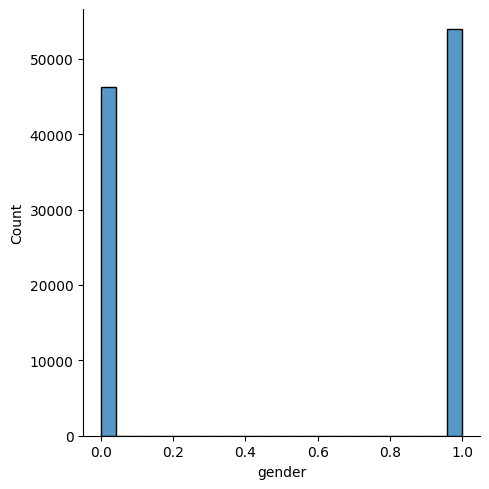

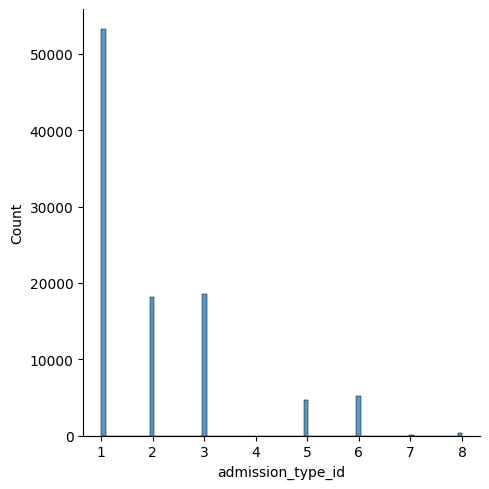

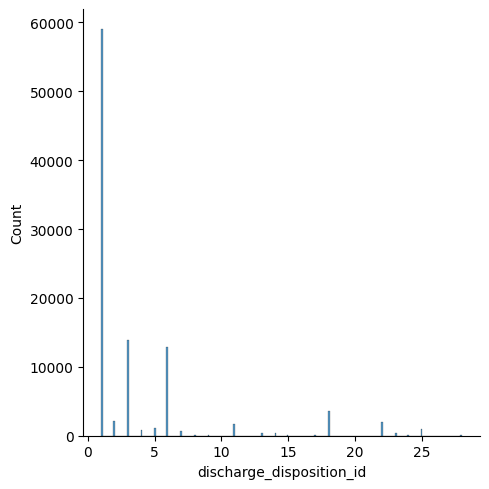

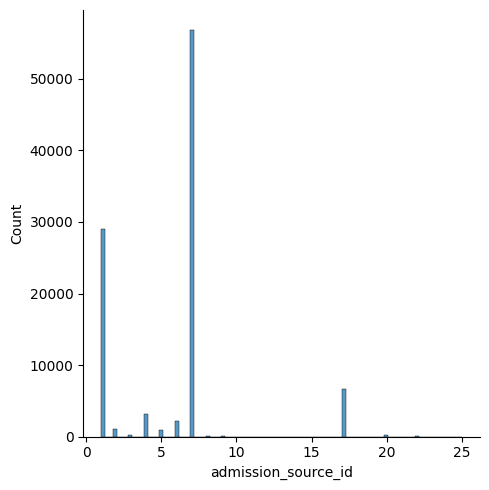

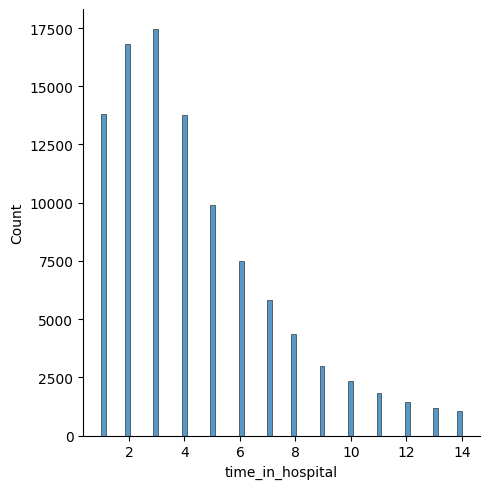

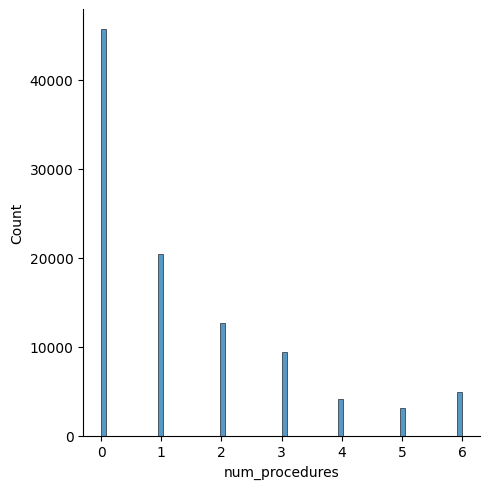

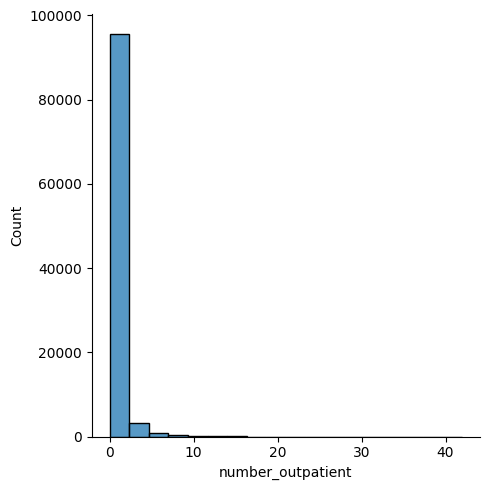

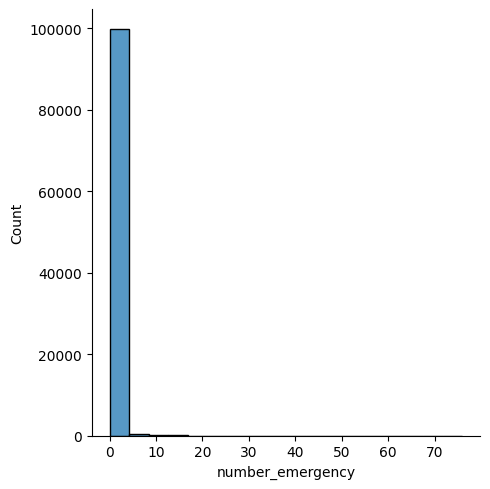

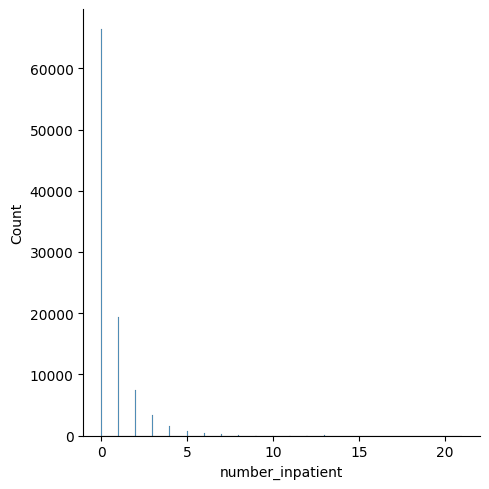

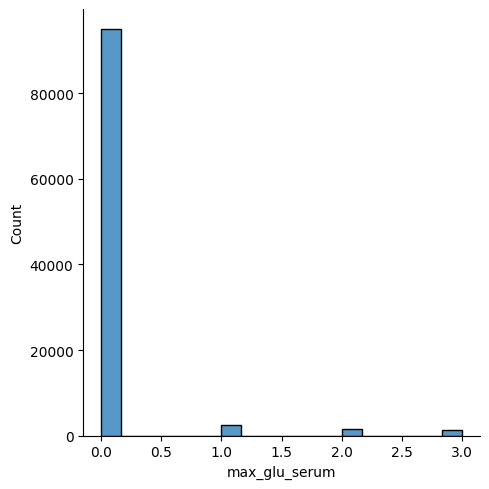

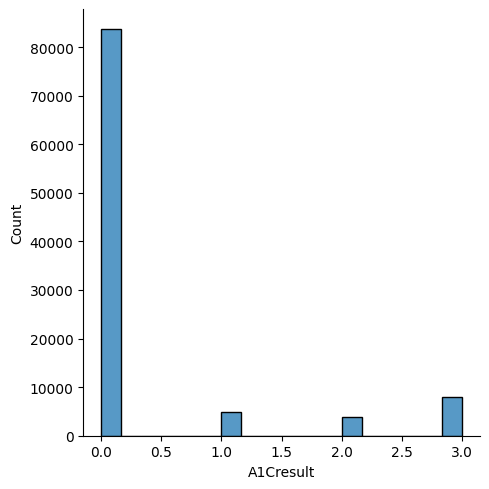

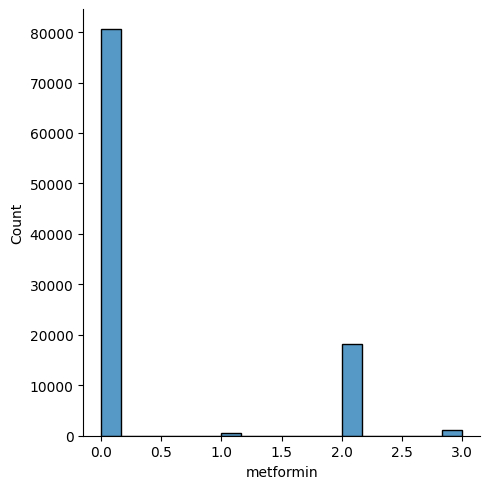

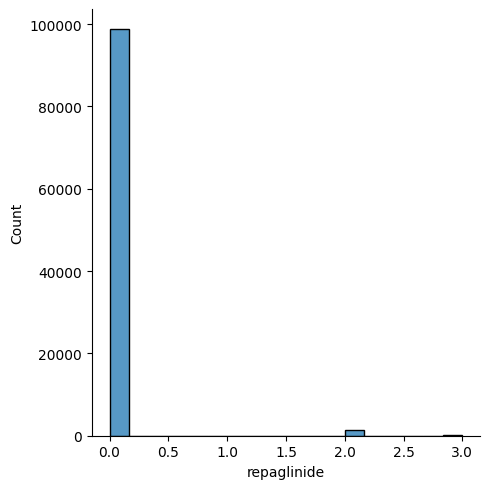

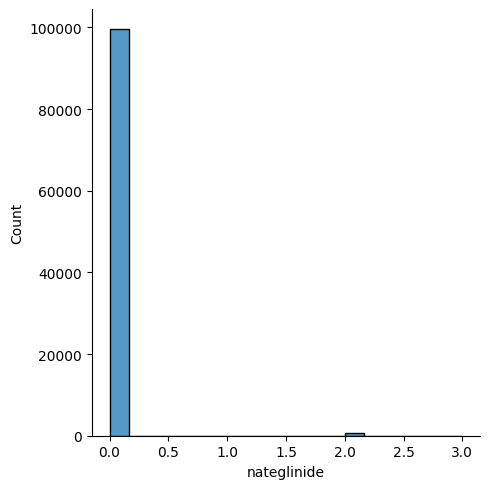

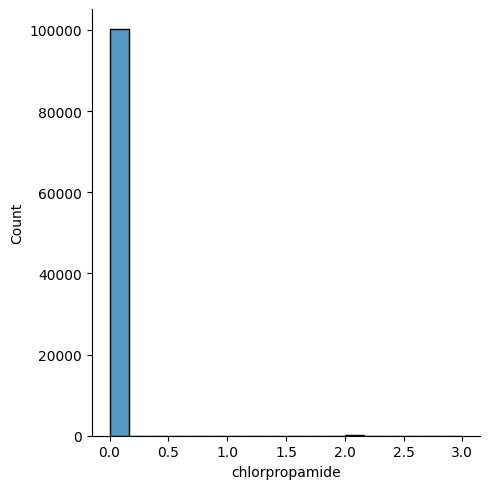

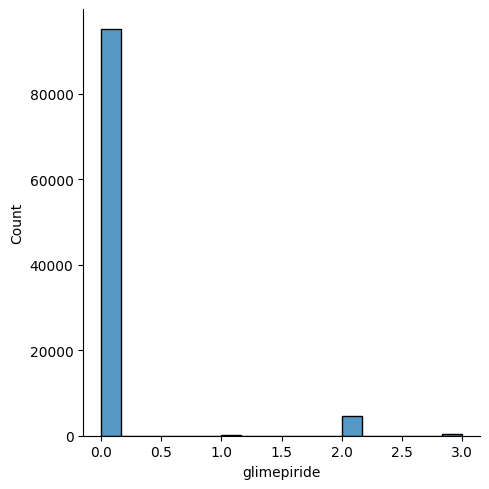

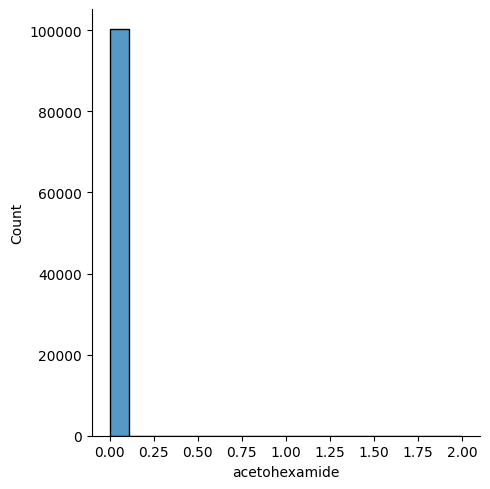

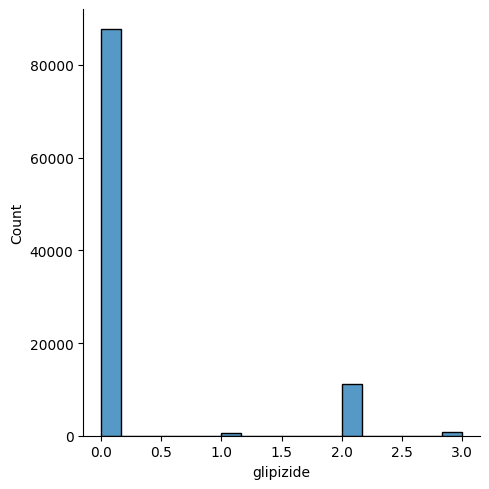

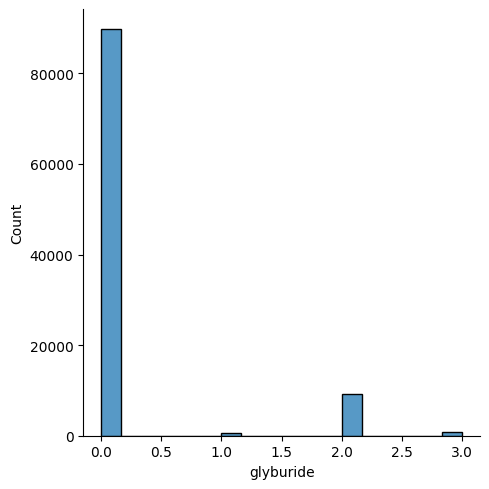

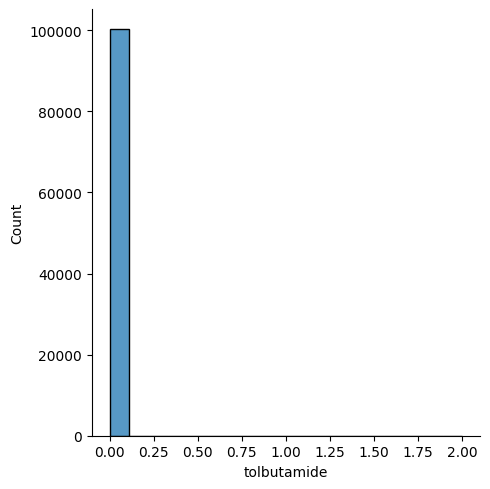

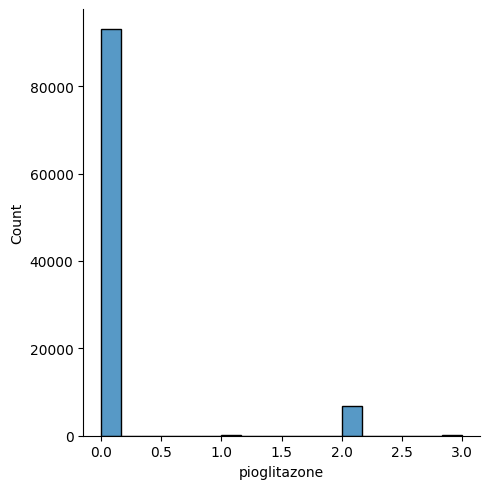

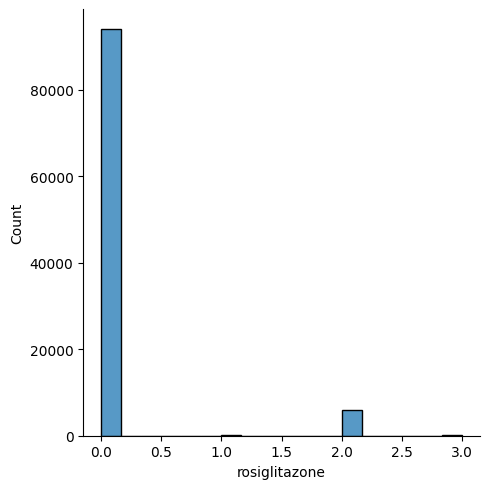

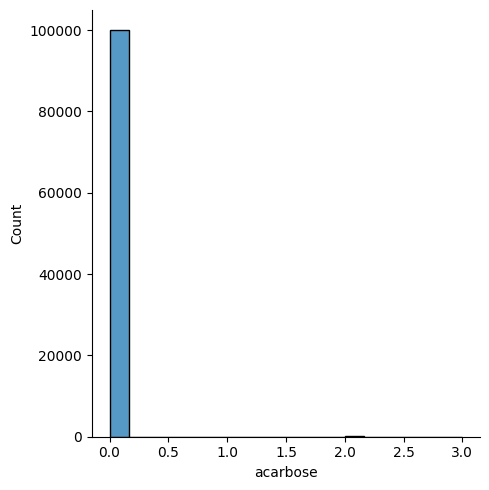

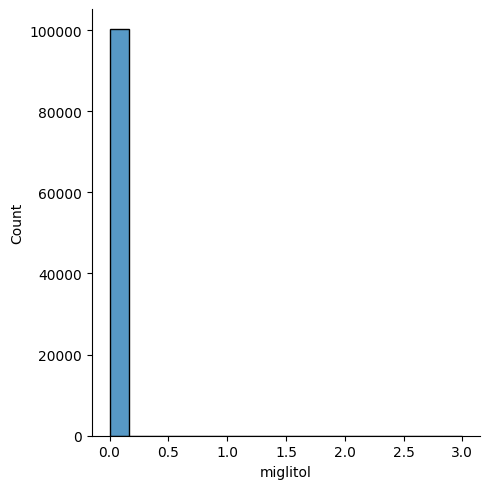

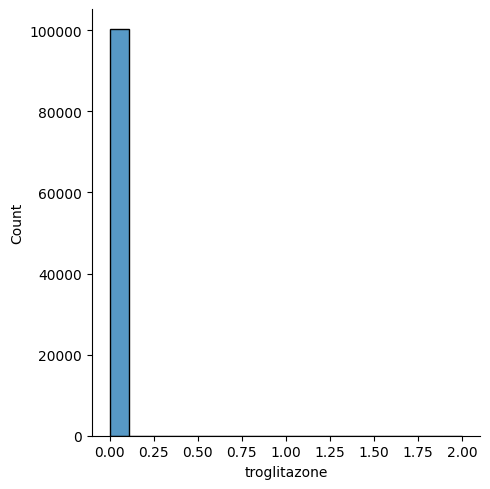

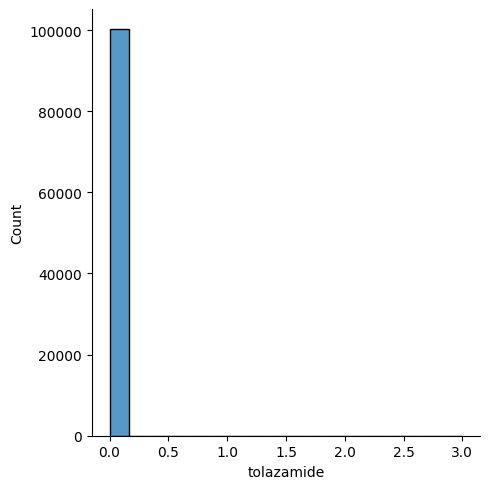

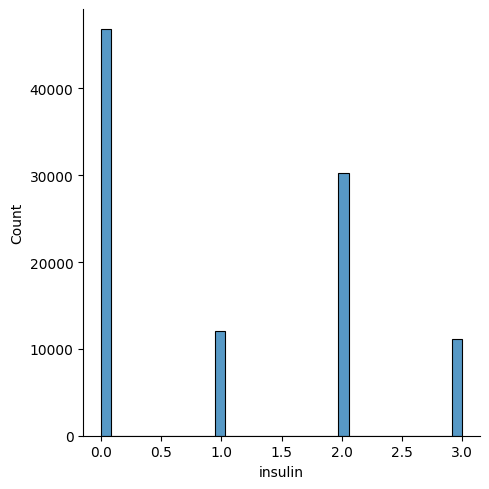

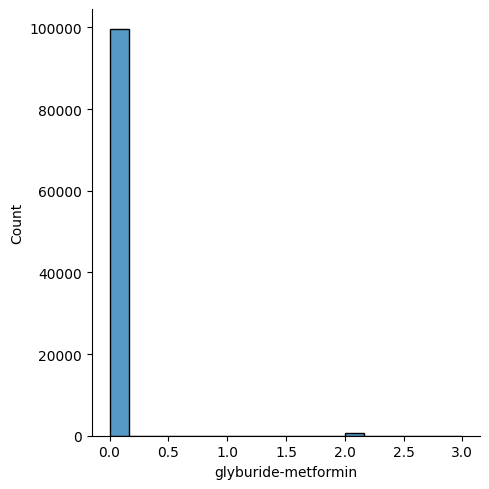

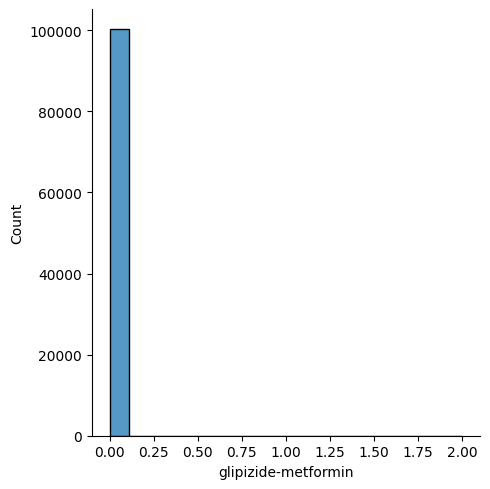

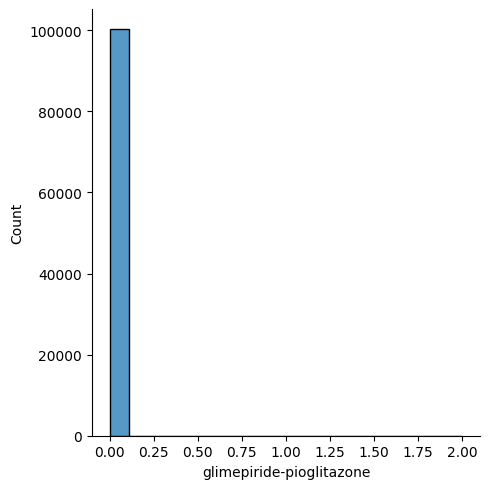

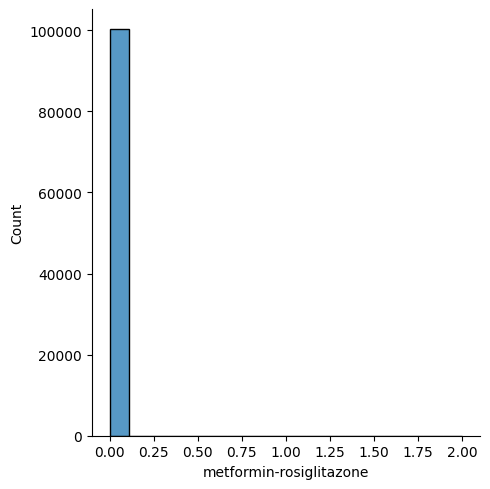

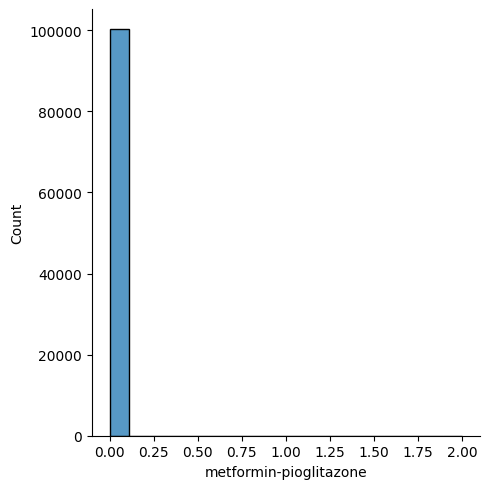

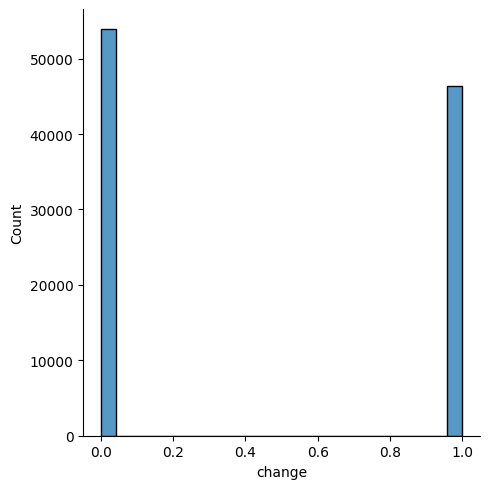

In [418]:
import seaborn as sns
from scipy.stats import linregress

# corr = df.corr()

# plt.figure(figsize = (20, 10))
# sns.heatmap(corr, annot=True, fmt=".2f", cmap='plasma', vmin=-1)

for c in df.columns:
  sns.displot(df[c])
  plt.show()

Below is my implementation of a neural network with an arbitrary number of layers. For forward propagation, I've decided to use ReLU activation functions for hidden layers, and a softmax activation function for the output layer. All gradients are calculated manually, with hidden and output layer activations hard-coded.

The derivative of ReLu is given by $$\begin{cases}0 & x<=0\\1 & x>0\end{cases}$$and the derivative of softmax is given by $$p-y$$where $p$ is the predicted probability. I also implemented gradient descent, where any of batch, mini-batch, and stochastic can be performed. I also implemented regularization in the form of early stopping with a validation set.

In [419]:
# Used for balancing the dataset
def load_dataset(dat, tar):
  vals, cts = np.unique(tar, return_counts=True)
  min_val = vals[np.argmin(cts)]
  min_ct = min(cts)
  new_dat = dat[tar == min_val]
  new_tar = tar[tar == min_val]
  for i, v in enumerate(vals):
    if v != min_val:
      indices = list(np.where(tar == v))[0]
      new_ind = np.random.choice(indices, min_ct)
      new_dat = np.append(new_dat, dat[new_ind], axis=0)
      new_tar = np.append(new_tar, tar[new_ind])
  return new_dat, new_tar


def ReLu(z):
  return np.maximum(z, 0)

class myNeuralNetwork:
  def __init__(self, train_data, train_targets, epochs, num_hidden_layers=2, hidden_dim=16, lr=0.01, batch_size = 32):
    self.batch_size = batch_size
    self.train_data = train_data
    self.train_targets = train_targets
    self.epochs = epochs
    self.learning_rate = lr
    self.hidden_layers = num_hidden_layers
    self.weights = [np.random.uniform(-0.1, 0.1, (np.shape(train_data)[1], hidden_dim))]
    self.biases = [np.random.uniform(-0.1, 0.1, (hidden_dim, 1))]
    for i in range(1, num_hidden_layers):
      self.weights.append(np.random.uniform(-0.1, 0.1, (hidden_dim, hidden_dim)))
      self.biases.append(np.random.uniform(-0.1, 0.1, (hidden_dim, 1)))
    self.weights.append(np.random.uniform(-0.1, 0.1, (hidden_dim, np.shape(train_targets)[1])))
    self.biases.append(np.random.uniform(-0.1, 0.1, (np.shape(train_targets)[1], 1)))

  def forward(self, data):
    z = []
    a = [data.T]
    for l in range(self.hidden_layers+1):
      z.append(np.matmul(self.weights[l].T, a[l]) + self.biases[l])
      # print(a[-1])
      if(l != self.hidden_layers):
        a.append(ReLu(z[l]))
      else:
        a.append(np.exp(z[l])/np.sum(np.exp(z[l]), axis = 0))
    return a, z

  def backward(self, a, z, tars):
    deltas = [0] * (self.hidden_layers+1)
    # Calculate gradient for the last layer. The derivative of softmax is given by p - y
    deltas[-1] = (a[-1]-tars.T).T
    for l in range(self.hidden_layers-1, -1, -1):
      deltas[l] = np.matmul(deltas[l+1], self.weights[l+1].T)*(np.where(z[l] > 0, 1, 0)).T
    return deltas


  # Trains using any vanilla version of gradient descent. Performs early stopping.
  def train(self, val_data, val_tar, val_epoch):
    N = np.shape(self.train_data)[0]
    best_cost = 10
    for e in range(self.epochs):
      print("Epoch {}".format(e))
      for batch in range(np.shape(self.train_data)[0]//self.batch_size):
        a, z = self.forward(self.train_data[self.batch_size*batch:self.batch_size*(batch+1)])
        dels = self.backward(a, z, self.train_targets[self.batch_size*batch:self.batch_size*(batch+1)])

        for l in range(self.hidden_layers+1):
          self.weights[l] -= self.learning_rate*(np.matmul(dels[l].T, a[l].T)).T
          self.biases[l] = self.biases[l]-self.learning_rate*np.array([np.mean(dels[l].T, axis=1)]).T
        if(batch % 100 == 0):
          print("Loss: {:.7f}".format(self.cost(a[-1], self.train_targets[self.batch_size*batch:self.batch_size*(batch+1)])))
      if(e % val_epoch == 0):
        a, _ = self.forward(val_data)
        cst = self.cost(a[-1], val_tar)
        print("Validation loss: {:.7f}".format(cst))
        if(cst > best_cost):
          break
        best_cost = cst
      print()


  # Calculates loss for entire sample
  def cost(self, preds, tars):
    return np.sum(-np.log(preds.T[range(np.shape(preds)[1]), np.argmax(tars, axis=1)]))/np.shape(preds)[1]

  # Returns predictions given data
  def predict(self, data):
    probs, _ = self.forward(data)
    probs = probs[-1]
    return np.argmax(probs.T, axis=1)


For implementing a 2-layer neural network with pytorch, I closely followed [this tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) -- specifically, how to add layers, what layers to use, and how to implement forward propagation. I ended up using an initial normalization layer. However, I don't think it's really necessary for the dataset I chose, since nearly all (if not all) of my variables are categorical with very low values. I believe that normalization is highly necessary for a dataset that contains a few continuous features with very high means and large variance, but here, it didn't seem to make too much of a difference. For specifics, I mainly just used [the pytorch documentation](https://pytorch.org/docs/stable/nn.html) to determine layers and inputs. I didn't really need to do much customization to the tutorial listed above in order to make this work, and I found picking this up relatively easy. I've also worked with PyTorch a bit before, which might have helped.

In [420]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class torchNeuralNetwork(nn.Module):
  def __init__(self, num_features, num_classes, num_hidden_layers=2, hidden_dim=16):
    super().__init__()
    self.layer_list = [nn.BatchNorm1d(num_features), nn.Linear(num_features, hidden_dim), nn.ReLU()]
    for l in range(1, num_hidden_layers):
      self.layer_list.append(nn.Linear(hidden_dim, hidden_dim))
      self.layer_list.append(nn.ReLU())
    self.layer_list.append(nn.Linear(hidden_dim, num_classes))
    self.layer_list.append(nn.Softmax(dim=1))
    self.layers = nn.Sequential(*self.layer_list)

  def forward(self, x):
    return self.layers(x)


For my training-validation-test split, I've chosen to take half of my dataset for training and sample validation and test sets at a 3:1:1 train:valid:test ratio from the rest of the dataset. Although any versions of vanilla gradient descent are possible with my implementation, I chose to use minibatch for training -- the more frequent updates make the loss converge much faster compared to batch gradient descent, and reduces variance compared to stochastic gradient descent. I did not have time to implement any optimization techniques such as momentum, RMSprop, or Adam. For hyperparamters, I'm using learning rate = 0.001, number of layers = 2, and layer dimension = 16.

In [421]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

dat = np.array(df)
tar = np.array(tars)
dat, tar = load_dataset(dat, tar)
print(np.shape(dat))
N = np.shape(dat)[0]

pct_train = 0.5
pct_val = pct_train + pct_train*0.3
pct_test = pct_val + pct_train*0.3
val_epoch = 1
indices = np.arange(N)
np.random.shuffle(indices)

targets = np.zeros((N, 3))
targets[range(N), tar] = 1

train_data = dat[indices[:int(pct_train*N)]]
train_targets = targets[indices[:int(pct_train*N)]]
val_data = dat[indices[int(pct_train*N):int(pct_val*N)]]
val_targets = targets[indices[int(pct_train*N):int(pct_val*N)]]
test_data = dat[indices[int(pct_val*N):int(pct_test*N)]]
test_targets = targets[indices[int(pct_val*N):int(pct_test*N)]]
mynn = myNeuralNetwork(train_data, train_targets, 100, lr=0.001)
mynn.train(val_data, val_targets, val_epoch)
print()
print("Test metrics:")
preds = mynn.predict(test_data)
print("f1 score: {:.5f}".format(f1_score(np.argmax(test_targets, axis=1), preds, average='macro')))
print("recall score: {:.5f}".format(recall_score(np.argmax(test_targets, axis=1), preds, average='macro')))
print("precision score: {:.5f}".format(precision_score(np.argmax(test_targets, axis=1), preds, average='macro')))
print("Overall accuracy: {:.2f} %".format(accuracy_score(np.argmax(test_targets, axis=1), preds)*100))

(33750, 33)
Epoch 0
Loss: 1.0998624
Loss: 1.1030487
Loss: 1.0907873
Loss: 1.0934547
Loss: 1.0871937
Loss: 1.1026302
Validation loss: 1.0965076

Epoch 1
Loss: 1.0906084
Loss: 1.1034590
Loss: 1.0799977
Loss: 1.0843783
Loss: 1.0738773
Loss: 1.1154285
Validation loss: 1.0893073

Epoch 2
Loss: 1.0851138
Loss: 1.0971730
Loss: 1.0378356
Loss: 1.0602771
Loss: 1.0558550
Loss: 1.1462115
Validation loss: 1.0669176

Epoch 3
Loss: 1.1034027
Loss: 1.1068963
Loss: 1.0053802
Loss: 1.0402932
Loss: 1.0505439
Loss: 1.1632777
Validation loss: 1.0625218

Epoch 4
Loss: 1.1098873
Loss: 1.1157867
Loss: 1.0020842
Loss: 1.0372801
Loss: 1.0467037
Loss: 1.1649101
Validation loss: 1.0608511

Epoch 5
Loss: 1.1124380
Loss: 1.1125317
Loss: 1.0036623
Loss: 1.0434750
Loss: 1.0527326
Loss: 1.1633165
Validation loss: 1.0592780

Epoch 6
Loss: 1.1162020
Loss: 1.1098828
Loss: 0.9986944
Loss: 1.0418772
Loss: 1.0544037
Loss: 1.1611086
Validation loss: 1.0584887

Epoch 7
Loss: 1.1180556
Loss: 1.1097208
Loss: 0.9957849
Loss: 1.

The code for the following training/validation/testing of my pytorch implementation was heavily taken from [this optimization tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html).

In [422]:
batch_size = np.shape(train_data)[1]
epochs = 200
learning_rate = 0.0005
valid_epoch = 1

model = torchNeuralNetwork(np.shape(train_data)[1], 3)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_loss = 10

for e in range(epochs):
  model.train()
  print("Epoch {}".format(e))
  for batch in range(np.shape(train_data)[0]//batch_size):
    pred = model(torch.Tensor(train_data[batch*batch_size : (batch+1)*batch_size]))
    loss = loss_fn(pred, torch.Tensor(train_targets[batch*batch_size : (batch+1)*batch_size]))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if(batch % 100 == 0):
      loss, current = loss.item(), batch * batch_size
      print(f"loss: {loss:>7f}  [{current:>5d}/{np.shape(train_targets)[0]:>5d}]")
  if(e % valid_epoch == 0):
    model.eval()
    with torch.no_grad():
      pred = model(torch.Tensor(val_data))
      loss = loss_fn(pred, torch.Tensor(val_targets))
      pred = np.argmax(pred, axis=1)
      print("Validation loss: {:.7f}".format(loss.item()))
      print("Validation accuracy: {:.2f}%".format(accuracy_score(np.argmax(val_targets, axis=1), pred)*100))
      if loss.item() > best_loss:
        break
      best_loss = loss.item()
  print()

model.eval()
with torch.no_grad():
  pred = model(torch.Tensor(test_data))
  pred = np.argmax(pred, axis=1)
  print("\nTest metrics:")
  print("f1 score: {:.5f}".format(f1_score(np.argmax(test_targets, axis=1), pred, average='macro')))
  print("recall score: {:.5f}".format(recall_score(np.argmax(test_targets, axis=1), pred, average='macro')))
  print("precision score: {:.5f}".format(precision_score(np.argmax(test_targets, axis=1), pred, average='macro')))
  print("Overall accuracy: {:.2f}%".format(accuracy_score(np.argmax(test_targets, axis=1), pred)*100))

# 42.93 43.59 42.81 43.55
# 42.55 43.38 42.93 42.65


Epoch 0
loss: 0.635642  [    0/16875]
loss: 0.639211  [ 3300/16875]
loss: 0.635852  [ 6600/16875]
loss: 0.636531  [ 9900/16875]
loss: 0.634935  [13200/16875]
loss: 0.613691  [16500/16875]
Validation loss: 0.6437047
Validation accuracy: 40.44%

Epoch 1
loss: 0.656918  [    0/16875]
loss: 0.636005  [ 3300/16875]
loss: 0.622573  [ 6600/16875]
loss: 0.637887  [ 9900/16875]
loss: 0.636639  [13200/16875]
loss: 0.615679  [16500/16875]
Validation loss: 0.6318216
Validation accuracy: 41.54%

Epoch 2
loss: 0.659626  [    0/16875]
loss: 0.637974  [ 3300/16875]
loss: 0.614612  [ 6600/16875]
loss: 0.642547  [ 9900/16875]
loss: 0.639328  [13200/16875]
loss: 0.616226  [16500/16875]
Validation loss: 0.6266121
Validation accuracy: 41.86%

Epoch 3
loss: 0.656877  [    0/16875]
loss: 0.637990  [ 3300/16875]
loss: 0.610105  [ 6600/16875]
loss: 0.643282  [ 9900/16875]
loss: 0.640432  [13200/16875]
loss: 0.617818  [16500/16875]
Validation loss: 0.6260912
Validation accuracy: 41.86%

Epoch 4
loss: 0.654333  




For hyperparameter tuning, I trained the model using both Adam and RMSprop optimization techniques while varying the learning rates.

For Adam, $lr \in \{0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005\}$ and for RMSprop, $lr \in  \{0.001, 0.0005, 0.0001, 0.00005, 0.00001\}$. I found that the Adam optimization worked best, with $lr=0.0005$. I also varied the number of layers and neurons in each layer, but found that the defaults worked best. Grid search was used as the method of choice for tuning -- my NN implementations don't run slowly enough to warrant random search.


Validation accuracy was used as the metric of selection -- the parameters were kept where the best validation accuracy was highest. Validation accuracy was used for hyperparameter tuning since it better reflects the results you would see in the test set than validation loss. Accuracy is also a lot more interpretable to me than other metrics such as f1/recall/precision score.

I used regularization in the form of early stopping for both my scratch NN implementation and my pytorch NN implementation. I think early stopping was highly important for this task -- without it, validation losses would increase quickly, and so stopping right when validation loss increased helped prevent overfitting.

******

**A few notes**: The day before I submitted this homework, all my work was lost. Of course, this was completely my fault, but it meant I had much less time to complete this. If I had more time, I would perform more EDA and handle the issue of unbalanced and missing data better. I would also like to do one-hot encoding, particularly with how many categorical variables the dataset has. I also wanted to look into upsampling more, which was a technique I read about for handling unbalanced data -- I figured downsampling was easier, but as a result, I reduced the possible number of samples. I also wanted to implement some optimization algorithms into my vanilla gradient descent algorithm, and do more hyperparameter tuning.

